In [2]:
# Cell 1: Set up GPU and inspect the file format
import torch
import safetensors
from safetensors import safe_open

# Set the GPU device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the file
file_path = "/data/scratch/kaivuh/kronfluencer/influence_results/tinystories/scores_tinystories_scores/pairwise_scores.safetensors"
with safe_open(file_path, framework="pt", device="cuda:2") as f:
    # Print the keys (tensor names) in the file
    print("Tensor keys:", f.keys())
    
    # Load and print information about the first tensor
    first_key = list(f.keys())[0]
    first_tensor = f.get_tensor(first_key)
    print(f"\nFirst tensor '{first_key}':")
    print("Shape:", first_tensor.shape)
    print("Data type:", first_tensor.dtype)
    print("Device:", first_tensor.device)
    print("First few values:", first_tensor.flatten()[:5])

Using device: cuda:2
Tensor keys: ['all_modules']

First tensor 'all_modules':
Shape: torch.Size([100, 1000])
Data type: torch.bfloat16
Device: cuda:2
First few values: tensor([ 1.3107e+05,  1.2560e+03,  2.7200e+03, -2.1600e+02,  1.1950e+02],
       device='cuda:2', dtype=torch.bfloat16)


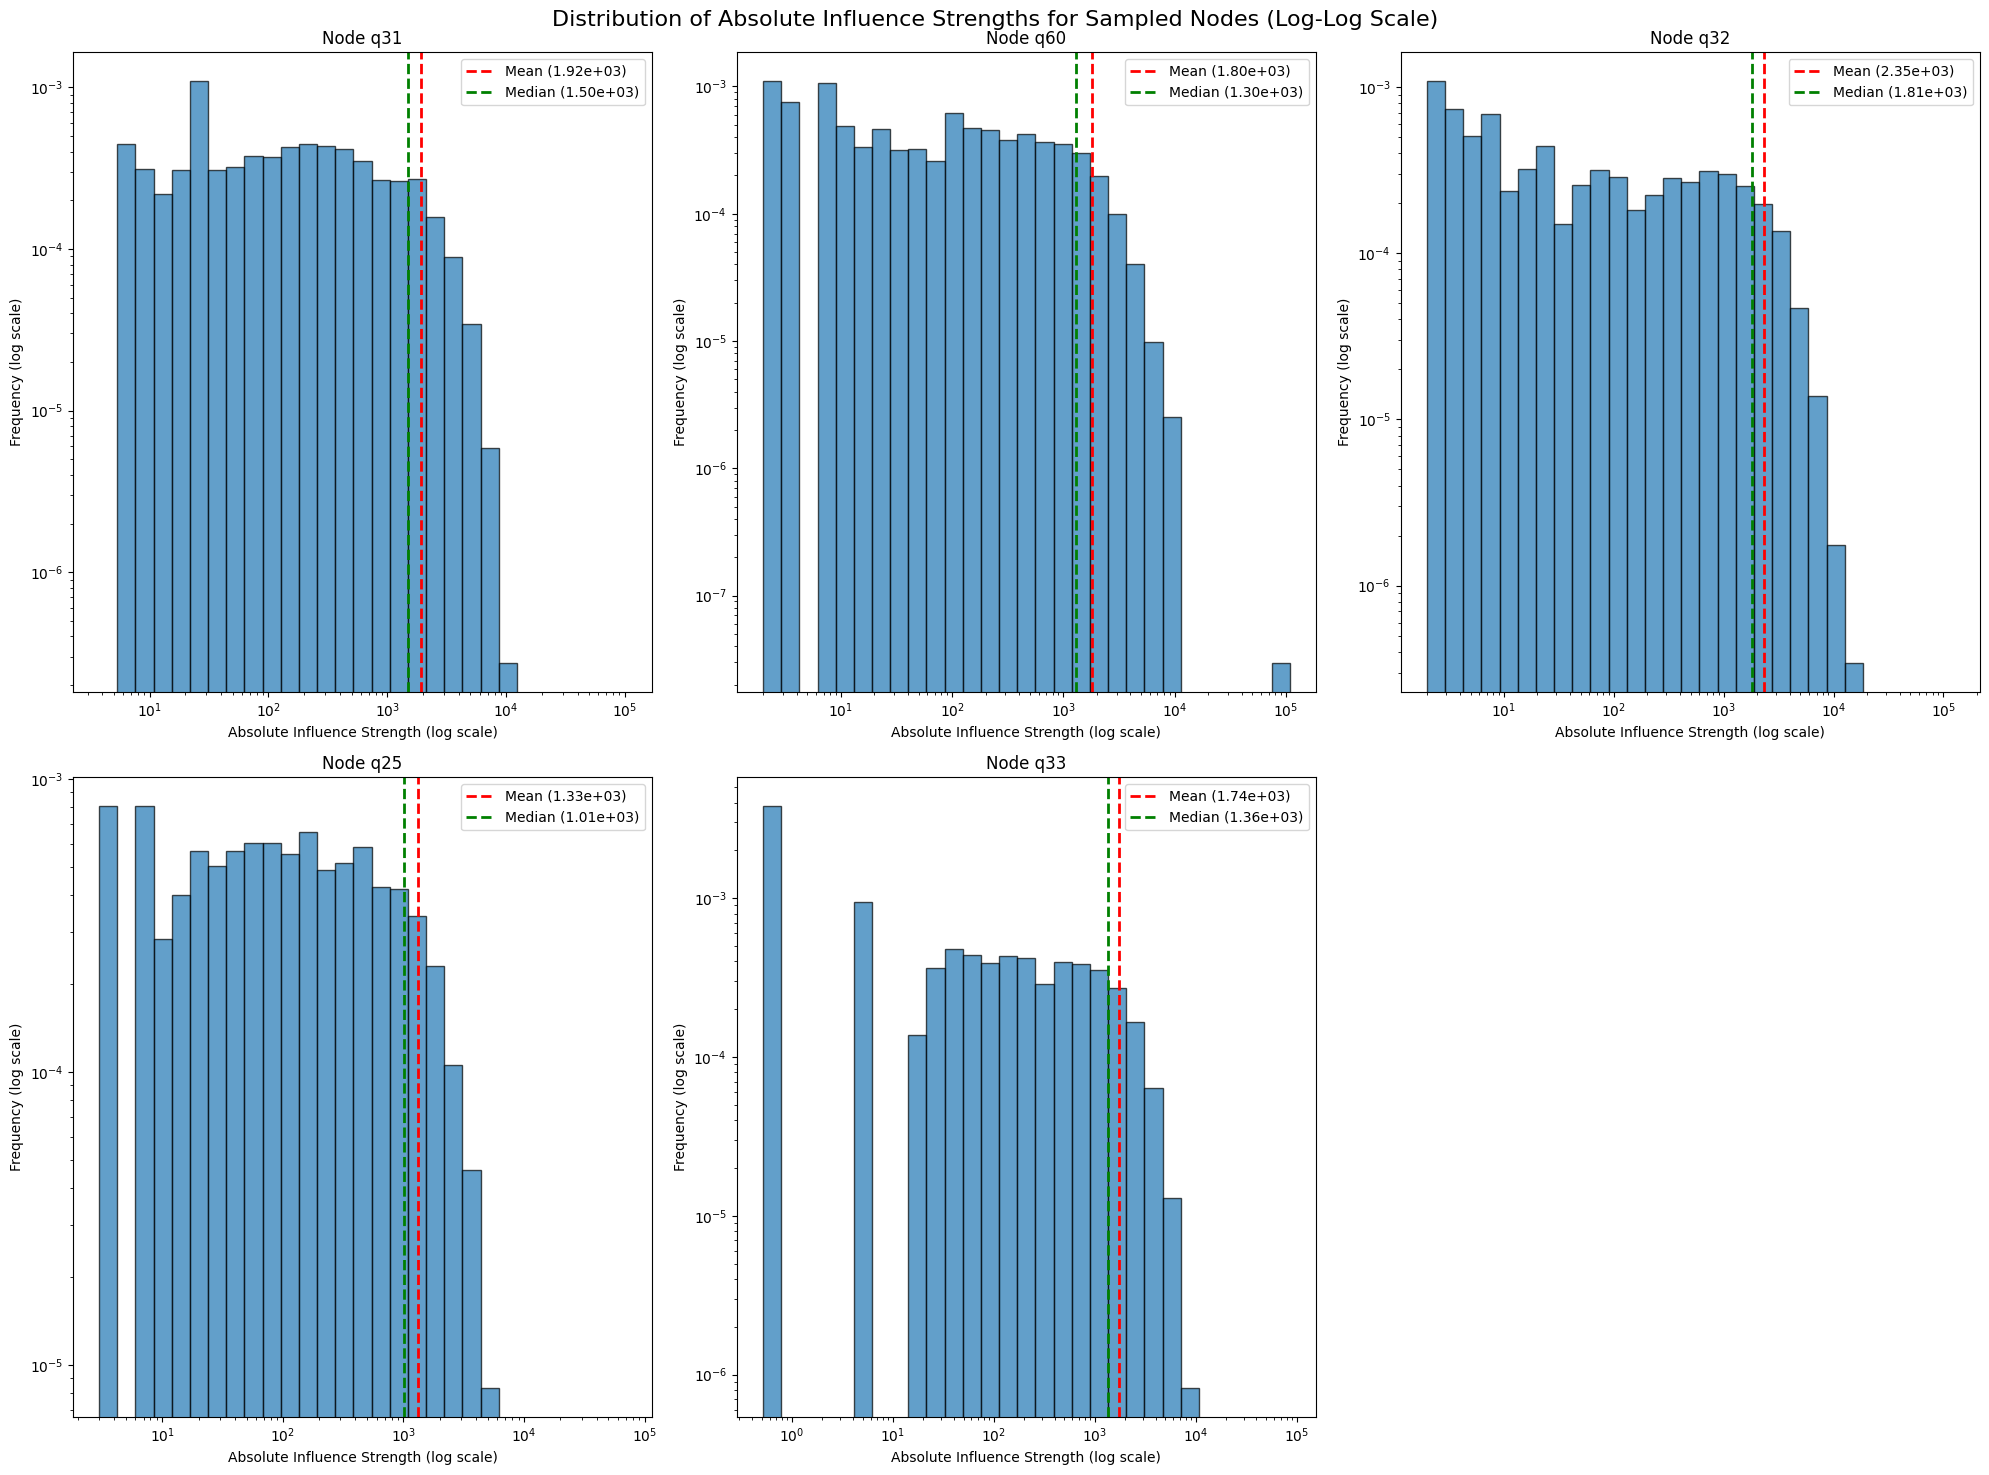


Summary statistics for sampled nodes (absolute values):

Node q31:
  Mean: 1.9215e+03
  Median: 1.5040e+03
  Std Dev: 3.5111e+03
  Min: 3.7500e+00
  Max: 1.0189e+05

Node q60:
  Mean: 1.8043e+03
  Median: 1.3000e+03
  Std Dev: 3.6882e+03
  Min: 2.0000e+00
  Max: 1.0803e+05

Node q32:
  Mean: 2.3491e+03
  Median: 1.8120e+03
  Std Dev: 4.2569e+03
  Min: 2.0000e+00
  Max: 1.2390e+05

Node q25:
  Mean: 1.3259e+03
  Median: 1.0120e+03
  Std Dev: 2.3997e+03
  Min: 3.0000e+00
  Max: 6.9632e+04

Node q33:
  Mean: 1.7432e+03
  Median: 1.3560e+03
  Std Dev: 2.9607e+03
  Min: 5.1562e-01
  Max: 8.5504e+04


In [7]:
# Cell 3: Sample nodes and plot their absolute influence strength distributions on log-log scales
import numpy as np
import matplotlib.pyplot as plt
import random

# Get the query nodes (assuming these are the first 100 nodes)
query_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0][:100]

# Sample 5 random nodes from the query nodes
sampled_nodes = random.sample(query_nodes, 5)

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle("Distribution of Absolute Influence Strengths for Sampled Nodes (Log-Log Scale)", fontsize=16)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot histograms for each sampled node
for i, node in enumerate(sampled_nodes):
    # Get the absolute weights of edges connected to this node
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    
    # Remove zero values (if any) for log scale
    weights = weights[weights > 0]
    
    # Plot histogram on log-log scale
    counts, bins, _ = axs[i].hist(weights, bins=np.logspace(np.log10(weights.min()), np.log10(weights.max()), 30), 
                                  density=True, alpha=0.7, edgecolor='black')
    
    # Set log scales
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
    axs[i].set_title(f"Node {node}")
    axs[i].set_xlabel("Absolute Influence Strength (log scale)")
    axs[i].set_ylabel("Frequency (log scale)")
    
    # Add mean and median lines
    mean_weight = np.mean(weights)
    median_weight = np.median(weights)
    axs[i].axvline(mean_weight, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_weight:.2e})')
    axs[i].axvline(median_weight, color='g', linestyle='dashed', linewidth=2, label=f'Median ({median_weight:.2e})')
    axs[i].legend()

# Remove the unused subplot
axs[-1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print summary statistics for each sampled node
print("\nSummary statistics for sampled nodes (absolute values):")
for node in sampled_nodes:
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    weights = weights[weights > 0]  # Remove zeros for log calculations
    print(f"\nNode {node}:")
    print(f"  Mean: {np.mean(weights):.4e}")
    print(f"  Median: {np.median(weights):.4e}")
    print(f"  Std Dev: {np.std(weights):.4e}")
    print(f"  Min: {np.min(weights):.4e}")
    print(f"  Max: {np.max(weights):.4e}")